In [1]:
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
# %matplotlib widget
basePath = "./sims.TNG/TNG50-1/output"
from tqdm import tqdm
import gc
import os

Snapshot_Init = 71
Snapshot_End = 99
Lbsg_Indices_Array = np.array(
    [117251, 300903, 324123, 329508, 382215, 400973, 419618, 457431, 460722, 490814]
)

h = 0.6774  # km/Mpc

m_dm = 4.5e-5  # E10M_Sum
m_dm_h = m_dm * h

Critial_Density = 1.27e-8  # E10M_Sum/kpc^3
Critial_Density_h = Critial_Density / h**2  # E10M_Sum/(kpc/h)^3


In [2]:
with h5py.File('stellar_circs.hdf5','r') as f:
    SubfindID = f['Snapshot_99/SubfindID'][()]
    CircAbove07Frac = f['Snapshot_99/CircAbove07Frac'][()]


In [3]:
LBSG_Sub_Index=list()
for target_subhalo_id in Lbsg_Indices_Array:
    w = np.where(SubfindID == target_subhalo_id)
    LBSG_Sub_Index.append(w[0][0])
    print('circ for subhalo: ', CircAbove07Frac[w])


circ for subhalo:  [0.39272636]
circ for subhalo:  [0.17321473]
circ for subhalo:  [0.1165873]
circ for subhalo:  [0.3625133]
circ for subhalo:  [0.23637083]
circ for subhalo:  [0.25091308]
circ for subhalo:  [0.16543594]
circ for subhalo:  [0.23387785]
circ for subhalo:  [0.36701438]
circ for subhalo:  [0.3130595]


In [4]:
Subhalo_Fields = ['SubhaloMassType', 'SubhaloVmax']
PartType4_Fields = ['Masses', 'GFM_Metallicity', 'GFM_StellarFormationTime']


In [5]:
Subhalos_Dict = il.groupcat.loadSubhalos(basePath, 99, fields=Subhalo_Fields)
condition = (Subhalos_Dict['SubhaloMassType'][:, 4] > 0.1) & (
    Subhalos_Dict['SubhaloMassType'][:, 4] < 100)
Galaxies_Indices = np.where(condition)[0]
Galaxies_Indices.shape


(2620,)

In [6]:
Sub_Index=list()
for id in Galaxies_Indices:
    w = np.where(SubfindID == id)[0][0]
    Sub_Index.append(w)
Sub_Index=np.array(Sub_Index)


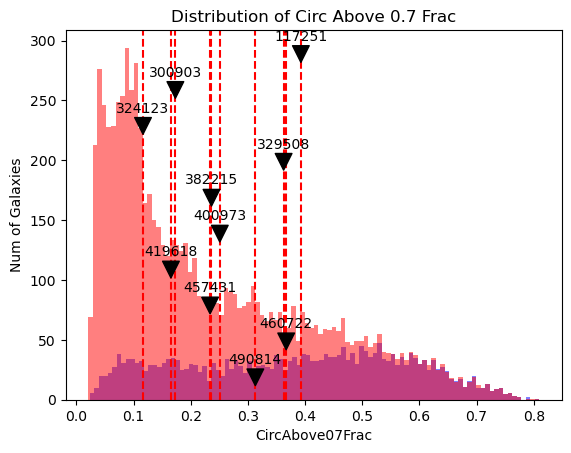

In [9]:
plt.hist(CircAbove07Frac[Sub_Index],100,alpha=0.5,color='b')
plt.hist(CircAbove07Frac,100,alpha=0.5,color='r')
plt.xlabel('CircAbove07Frac')
plt.ylabel('Num of Galaxies')
plt.title('Distribution of Circ Above 0.7 Frac')
highlight_values = np.array(CircAbove07Frac[LBSG_Sub_Index])
height = 300
for value in highlight_values:
    plt.axvline(x=value, color='red', linestyle='dashed',
               linewidth=1.5, label=f'Value: {value}')
    index = np.where(highlight_values == value)[0][0]
    plt.annotate(f'{Lbsg_Indices_Array[index]}', xy=(value, height-20), xytext=(value, height), ha='center', fontsize=10,
                arrowprops=dict(facecolor='black', shrink=0.1))
    height -= 30
plt.show()


In [9]:
Mass_Averaged_SFT = list()
Current_Snapshot=99
for Subhalo_Id in tqdm(Galaxies_Indices):
    Subhalo_Dict = il.snapshot.loadSubhalo(
        basePath, Current_Snapshot, Subhalo_Id, partType=4, fields=PartType4_Fields)
    if (len(Subhalo_Dict)) == 1:
        continue
    Stars_Indices = np.where(Subhalo_Dict['GFM_StellarFormationTime'] > 0)[0]
    Mass_Averaged_SFT.append((Subhalo_Dict['Masses'][Stars_Indices]*Subhalo_Dict['GFM_StellarFormationTime']
                             [Stars_Indices]).sum()/Subhalo_Dict['Masses'][Stars_Indices].sum())


100%|██████████| 2620/2620 [08:13<00:00,  5.31it/s] 


In [13]:
LBSG_Mass_Averaged_SFT=list()
for Subhalo_Id in Lbsg_Indices_Array:
    Subhalo_Dict = il.snapshot.loadSubhalo(
        basePath, Current_Snapshot, Subhalo_Id, partType=4, fields=PartType4_Fields)
    if (len(Subhalo_Dict)) == 1:
        continue
    Stars_Indices = np.where(Subhalo_Dict['GFM_StellarFormationTime'] > 0)[0]
    LBSG_Mass_Averaged_SFT.append((Subhalo_Dict['Masses'][Stars_Indices]*Subhalo_Dict['GFM_StellarFormationTime']
                             [Stars_Indices]).sum()/Subhalo_Dict['Masses'][Stars_Indices].sum())


Text(0.5, 1.0, 'Averaged SFT with Frac')

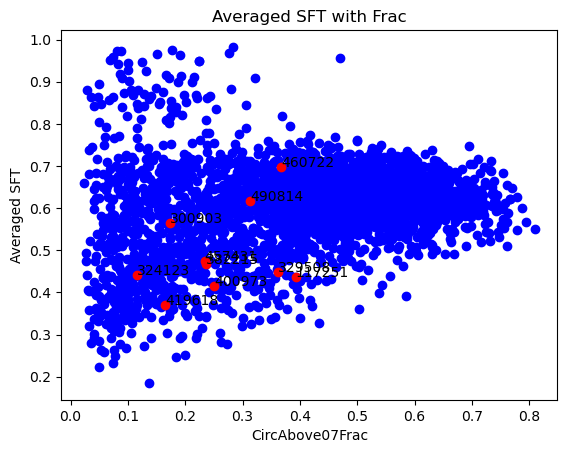

In [20]:
fig, ax = plt.subplots()

ax.scatter(CircAbove07Frac[Sub_Index], Mass_Averaged_SFT, color='b')
ax.scatter(CircAbove07Frac[LBSG_Sub_Index], LBSG_Mass_Averaged_SFT, color='red')

for i, txt in enumerate(Lbsg_Indices_Array):
    ax.annotate(txt, (CircAbove07Frac[LBSG_Sub_Index][i], LBSG_Mass_Averaged_SFT[i]))

ax.set_xlabel('CircAbove07Frac')
ax.set_ylabel('Averaged SFT')
ax.set_title('Averaged SFT with Frac')
